# Effect of weights in the power spectrum estimator and the modelling

## Formalism
In power spectrum analysis, there are two types of weighting that exist in the estimator. 

First of all, there is a **field-level** weighting that directly applies to the tracer field. For example, for galaxy clustering, the galaxy number density is modified by the redshift kernel, i.e. $\rm dn/dz$, of the sample as well as the survey geometry. For HI, this is usually ignored, but effects such as bandpass errors are effectively in this category.

On the other hand, there can be a **grid-level** weighting that is up to the choice of the analyst. For example, in galaxy clustering, it is common to perform the gridding of the galaxy catalogue to the mesh grids and then apply a FKP weighting. In HI, it is common to apply an inverse noise variance weighting based on the number of data time stamps in each grid.

These two weightings are different **because there are several steps of data processing in between the two**. In `meer21cm`, the implementation of the mock signal modelling follows:

$$
\begin{split}
{\delta}^{\rm obs}_{1,2} (\vec{x}) =  \Bigg[\bigg[\Big[\big[{\delta}^{\rm theory}_{1,2} (\vec{x})  \circledast B_{1,2}(\vec{x})\big] 
 \times {w}^f_{1,2}(\vec{x})\Big]
 \circledast G^{\rm map}_{1,2}(\vec{x})\bigg] 
 \circledast G^{\rm grid}_{1,2}(\vec{x})\Bigg] 
 \times {w}^g_{1,2}(\vec{x})
\end{split}
$$
where ${w}^{f/g}_{1,2}$ denotes the field/grid weights for the first/second tracer, $\circledast$ denotes convolution, $B_{1,2}$ denotes the primary beam attenuation and channelisation, $G_{\rm map}$ denotes the effect of sky map-making and $G_{\rm grid}$ denotes the effect of gridding.

On the other hand, at the level of the power spectrum, we then model the clustering as

$$
\begin{split}
{P}^{\rm obs}_{1,2} (\vec{k}) =  \bigg[ P^{\rm theory}_{1,2} 
\, \tilde{B}_{1}\,\tilde{B}_{2} \, \tilde{G}_{1}^{\rm map}\, \tilde{G}_{2}^{\rm map}\, \tilde{G}_{1}^{\rm grid}\, \tilde{G}_{2}^{\rm grid}\bigg] \circledast 
\bigg[ \tilde{w}^f_{1}\tilde{w}^g_{1} \big( \tilde{w}^f_{2}\tilde{w}^g_{2}  \big)^* \bigg]
\end{split}
$$

Note the **implicit simplification** here: We are effectively assuming that the multiplication of $w^f$ and the convolution of map-making as well as gridding are **commutable**. If you think about the density field in Fourier space, it is first convolved with $\tilde{w}^f$ and then multiplied by the gridding effects. Swapping the two means that you assume $\tilde{w}^f(\vec{k})$ is a very narrow window in $k$, so that within that narrow tophat, $\tilde{G}^{\rm map}$ and $\tilde{G}^{\rm grid}$ can be treated as constants and therefore the order of applying these effects does not matter.

For this note, let us use mock simulations to study the effects of the two weightings. We use flat sky approximation and only look at galaxy auto-power, so that there is no beam, map-making or gridding ($B = G_{\rm map} = G_{\rm grid} = \delta_{\rm D}$, the Dirac delta).

In [ ]:
from meer21cm.mock import MockSimulation
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows
from scipy.interpolate import interp1d
from meer21cm.plot import plot_map
from meer21cm.power import power_weights_renorm
from meer21cm.power import get_shot_noise_galaxy

/Users/zhaotingchen/miniconda3/envs/meer21cm/lib/python3.10/site-packages/halomod/halo_model.py:32: UserWarning: Warning: Some Halo-Exclusion models have significant speedup when using Numba
  from .halo_exclusion import Exclusion, NoExclusion


In [2]:
# start from scratch, generate galaxy catalogue that is trimmed and have dndz
mock = MockSimulation(
    survey="meerklass_2021",
    band="L",
)
dndz = interp1d(np.linspace(mock.z_ch.min(),mock.z_ch.max(),100),windows.blackmanharris(100),bounds_error=False,fill_value=0)
raminMK, ramaxMK = 334, 357
decminMK, decmaxMK = -35, -26.5
ra_range = (raminMK, ramaxMK)
dec_range = (decminMK, decmaxMK)
# all the other settings follow the default, which corresponds to the MeerKLASS L-band deep-field survey
mock = MockSimulation(
    survey="meerklass_2021",
    band="L",
    flat_sky=True,
    #num_discrete_source=1e5,
    num_discrete_source=1e5,
    #seed=47,
    tracer_bias_2=1.0,
    mean_amp_1='average_hi_temp',
    ra_range=ra_range,
    dec_range=dec_range,
    discrete_source_dndz=dndz,
    #seed=101,
)
#mock.w_HI = np.ones_like(mock.w_HI)
#mock.W_HI = np.ones_like(mock.W_HI)
# generate the mock tracer
mock.propagate_mock_tracer_to_gal_cat()
# grid to galaxy number count
gal_count,_,_ = mock.grid_gal_to_field()

In [3]:
mock.k1dbins = np.linspace(
    mock.k_mode[mock.k_mode!=0].min(),
    mock.k_mode[mock.k_mode!=0].max(),
    16
)

let us first take a look at the galaxies we generate. The input asserts two field-level weights, which is the survey area:

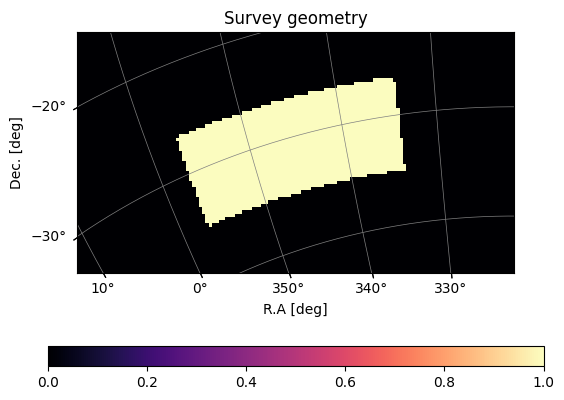

In [6]:
plot_map(mock.W_HI,mock.wproj,title='Survey geometry')

and the redshift kernel:

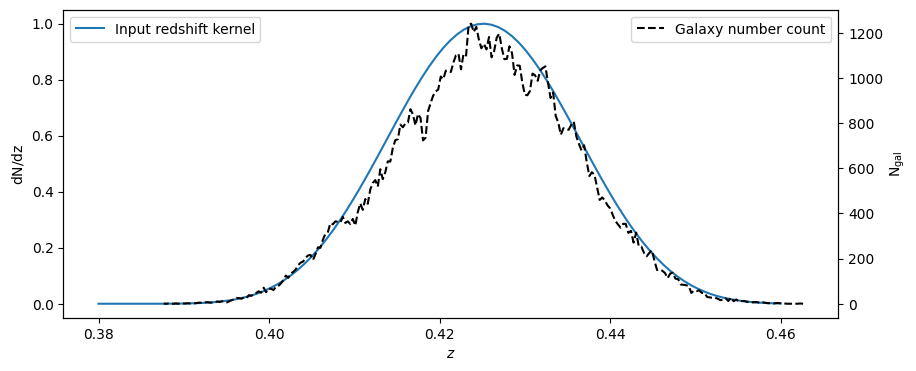

In [4]:
plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(np.linspace(0.38,0.46,100),dndz(np.linspace(0.38,0.46,100)),label='Input redshift kernel')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\rm dN/dz$')
ax.legend(loc='upper left')
ax2 = ax.twinx()
ax2.plot(mock.z_ch,gal_count.sum(axis=(0,1)),label='Galaxy number count',
         ls='--',c='k')
ax2.set_ylabel(r'$\rm N_{gal}$')
ax2.legend(loc='upper right')


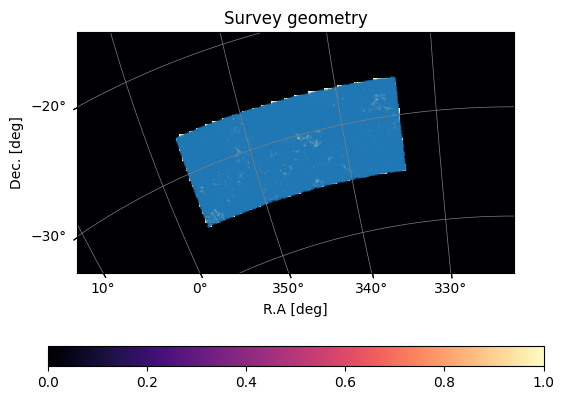

In [5]:
# visualise the galaxy positions:
plot_map(mock.W_HI,mock.wproj,title='Survey geometry')
ax = plt.gca()
ax.scatter(mock.ra_gal,mock.dec_gal,s=0.1,alpha=0.5,
           transform=ax.get_transform('world'),)

## Field-level weights

We can then assemble the field-level weights:

In [6]:
# the dndz projected to the 3D box
dndz_box = mock.discrete_source_dndz(mock._box_voxel_redshift)
# the survey geometry
geomoetry_gal = mock.w_HI.copy()
# the field-level weights
wf_gal = dndz_box * geomoetry_gal

And then calculate the power spectrum, where the weighting is automatically taken care of:

In [20]:
# galaxy number count to overdensity
mock.field_2 = gal_count
mock.weights_field_2 = wf_gal
mock.mean_center_2 = True
mock.unitless_2 = True
# G_grid = 1
mock.compensate = [False,False]
# G_map = 1
mock.include_sky_sampling = [False,False]
# B = 1
mock.include_beam = [False,False]
mock.weights_grid_2 = None
# get the 3D power spectrum
power_mock = mock.auto_power_3d_2.copy()
# since we haven't set any weight, the model power is not convolved
power_model_no_weights = mock.auto_power_matter_model.copy()
# shot noise is survey volume over number of galaxies
#shot_noise = np.prod(mock.box_len) / (gal_count).sum() * power_weights_renorm(wf_gal, wf_gal) * wf_gal.mean()**2
shot_noise = get_shot_noise_galaxy(gal_count, mock.box_len, mock.weights_field_2)

Visualise it in 1D:

In [21]:
power_1d_mock,keff,nmodes = mock.get_1d_power(power_mock)

power_1d_model_weights,_,_ = mock.get_1d_power(mock.auto_power_tracer_2_model)



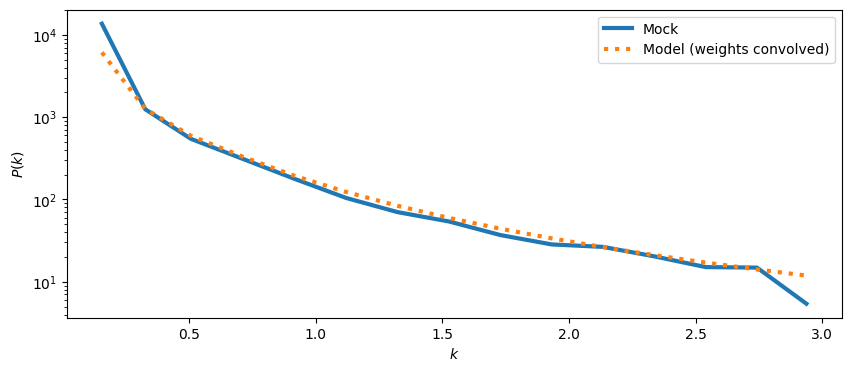

In [22]:
plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(keff,(power_1d_mock)-shot_noise,label='Mock',ls='-',lw=3)
ax.plot(keff,power_1d_model_weights,label='Model (weights convolved)',ls=':',lw=3)

ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')
ax.set_yscale('log')
ax.legend()


Or you can visualise the power spectrum in 2D:

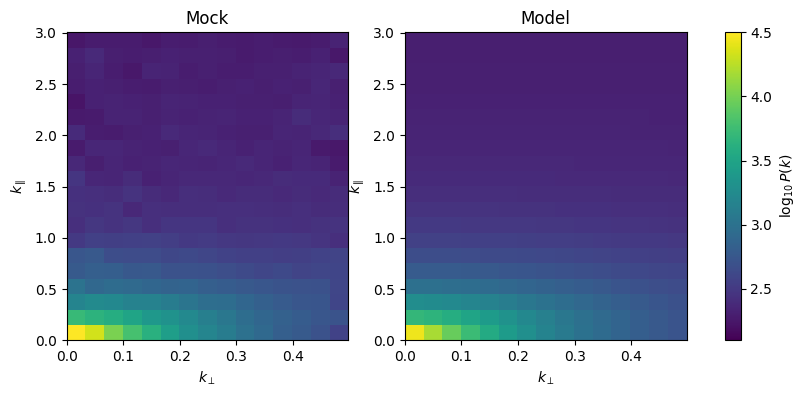

In [23]:
mock.kperpbins = np.linspace(0,mock.k_perp.max(),16)
mock.kparabins = np.linspace(0,mock.k_para.max(),21)
pmock_cy,_ = mock.get_cy_power(power_mock)
pmock_cy_weights,_ = mock.get_cy_power(mock.auto_power_tracer_2_model + shot_noise)
fig,axes = plt.subplots(1,2,figsize=(10,4))
axes[0].pcolormesh(
    mock.kperpbins,mock.kparabins,np.log10(pmock_cy).T,
    vmin=2.1,vmax=4.5,
)
im = axes[1].pcolormesh(
    mock.kperpbins,mock.kparabins,np.log10(pmock_cy_weights).T,
    vmin=2.1,vmax=4.5,
)
axes[0].set_xlabel(r'$k_\perp$')
axes[0].set_ylabel(r'$k_\parallel$')
axes[0].set_title('Mock')
axes[1].set_xlabel(r'$k_\perp$')
axes[1].set_ylabel(r'$k_\parallel$')
axes[1].set_title('Model')
plt.colorbar(im,ax=axes[:],label=r'$\log_{10} P(k)$')

All good. Now let us pretend that `wf_gal` does not exist. That is, I treat `gal_count` as if the geometry and the redshift kernel are all uniform:

In [24]:
# galaxy number count to overdensity
mock.field_2 = gal_count
# disable field weighting
mock.weights_field_2 = None
mock.mean_center_2 = True
mock.unitless_2 = True
# G_grid = 1
mock.compensate = [False,False]
# G_map = 1
mock.include_sky_sampling = [False,False]
# B = 1
mock.include_beam = [False,False]
mock.weights_grid_2 = None
# get the 3D power spectrum
power_mock = mock.auto_power_3d_2.copy()
# since we haven't set any weight, the model power is not convolved
power_model_no_weights = mock.auto_power_matter_model.copy()
# shot noise is survey volume over number of galaxies
#shot_noise = np.prod(mock.box_len) / (gal_count).sum() * power_weights_renorm(wf_gal, wf_gal) * wf_gal.mean()**2
shot_noise_nw = get_shot_noise_galaxy(gal_count, mock.box_len, mock.weights_field_2)

power_1d_mock_nw,keff,nmodes = mock.get_1d_power(power_mock)

power_1d_model_nw,_,_ = mock.get_1d_power(mock.auto_power_tracer_2_model)



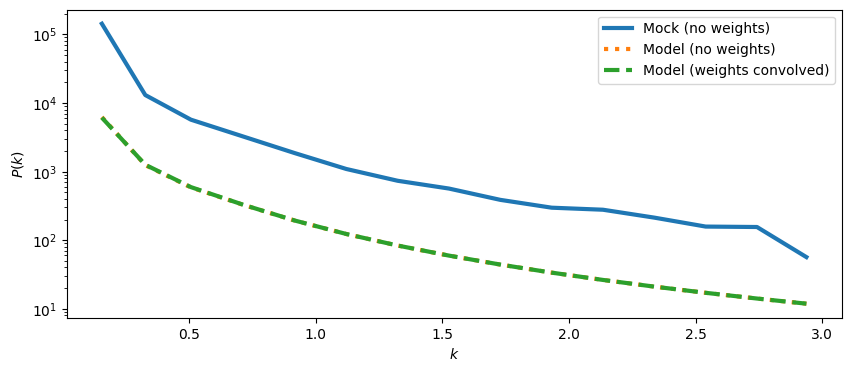

In [26]:
plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(keff,(power_1d_mock_nw)-shot_noise_nw,label='Mock (no weights)',ls='-',lw=3)
ax.plot(keff,power_1d_model_nw,label='Model (no weights)',ls=':',lw=3)
ax.plot(keff,power_1d_model_weights,label='Model (weights convolved)',ls='--',lw=3)

ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')
ax.set_yscale('log')
ax.legend()


Two things stand out:

1. The model power spectrum, with or without weights, is almost identical. This is because the amplitude of the model power spectrum is always renormalised, so that the only different is the convolution of model and weights in Fourier space. This leads to a tiny difference:

In [27]:
power_1d_model_nw/power_1d_model_weights

array([1.01957014, 0.98725196, 0.98943276, 0.99646451, 0.99801497,
       0.99876734, 0.99908082, 0.99934886, 0.99946504, 0.99953185,
       0.99969732, 0.99970794, 0.99975271, 0.99976668, 0.99836299])

Second, note that the measured power spectrum has an artificial increase in amplitude comparing to the input model. There are two issues from neglecting the weights:
- The mean galaxy number density is wrong (Therefore also the shot noise is wrong)
- The power specturm estimator is not normalised.

We can manually correct for it (which is automatically performed in `meer21cm`):

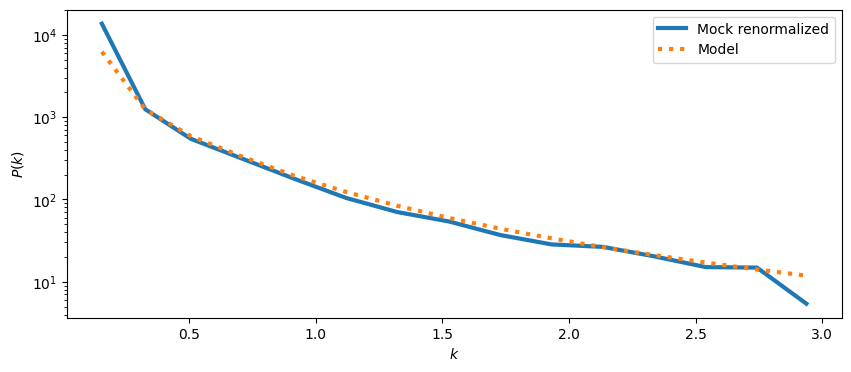

In [29]:
# estimator renormalisation
renorm_weights = power_weights_renorm(wf_gal, wf_gal)
# power spectrum is corrected by the mean as well as the estimator renormalisation
shot_noise_corrected = np.prod(mock.box_len) / (gal_count).sum() * renorm_weights * wf_gal.mean()**2
power_1d_mock_nw_corrected = (power_1d_mock_nw)*renorm_weights * wf_gal.mean()**2
plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(keff,power_1d_mock_nw_corrected - shot_noise_corrected,label='Mock renormalized',ls='-',lw=3)
ax.plot(keff, power_1d_model_nw, label='Model',ls=':',lw=3)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')
ax.set_yscale('log')
ax.legend()

Again, in practice, this is automatically taken care of.

## Grid level weights
Now suppose that you want to also apply some weights yourself on the gridded field before taking DFT. This weighting can be a taper function, or inverse noise variance weighting in the case of HI, etc.

Note that, it is usually assumed that the HI only has grid level weights and galaxy only has field level weights. **If both weights are non-uniform**, the renormalisation becomes highly-nontrivial unless the approximation for the narrow Fourier profile holds as mentioned at the beginning of this notebook.

In [31]:
taper = (
    windows.blackmanharris(mock.box_ndim[0])[:,None,None] # taper in x-direction
    * windows.blackmanharris(mock.box_ndim[1])[None,:,None] # taper in y-direction
    * windows.blackmanharris(mock.box_ndim[2])[None,None,:] # taper in z-direction
)
#taper/=taper.mean()
# specify the grid-level weights
mock.weights_grid_2 = (taper.copy())
mock.weights_field_2 = wf_gal

In [45]:
power_1d_mock,keff,nmodes = mock.get_1d_power(mock.auto_power_3d_2)
shot_noise = get_shot_noise_galaxy(gal_count, mock.box_len, mock.weights_field_2 * mock.weights_grid_2)

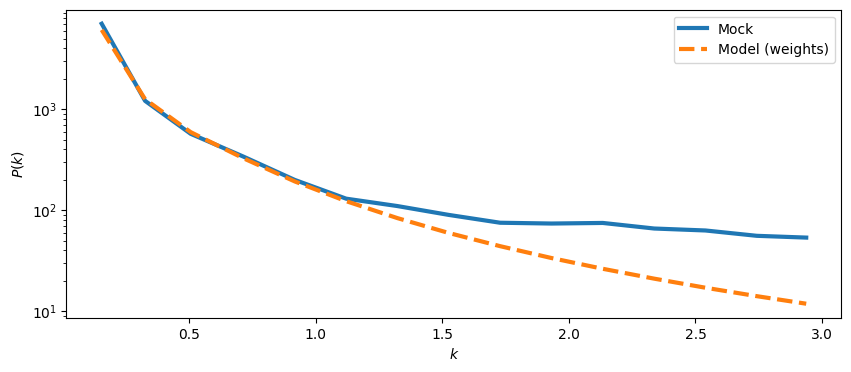

In [46]:
plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(keff,power_1d_mock - shot_noise,label='Mock',ls='-',lw=3)
ax.plot(keff,power_1d_model_weights,label='Model (weights)',ls='--',lw=3)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')

ax.set_yscale('log')
ax.legend()

The shot noise calculation is off on small scales. In galaxy auto-power analysis, it is better to generate random galaxy catalogues following the survey geometry, and then to use the randoms to calculate the shot noise to include all the effects.

## Cross-power with different weights for each tracer

Now, let us generate HI data. HI typically has grid level weights associated with the estimator, for inverse noise variance weighting and tapering:

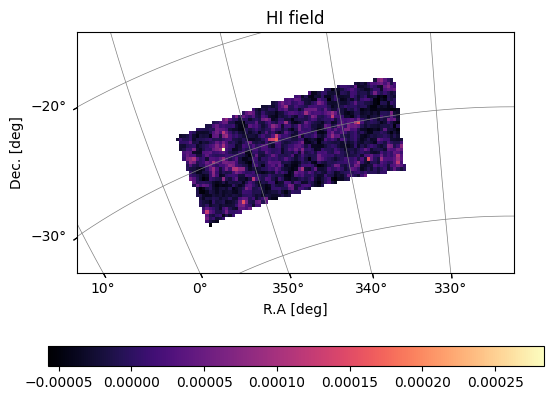

In [47]:
mock.data = mock.propagate_mock_field_to_data(mock.mock_tracer_field_1)
mock.trim_map_to_range()
plot_map(mock.data,mock.wproj,W=mock.W_HI,title='HI field')

In [48]:
mock.field_1 = mock.data
# taper in z-direction
mock.weights_grid_1 = mock.w_HI * windows.blackmanharris(mock.box_ndim[-1])[None,None,:]
mock.weights_field_1 = None

power_1d_hi_mock,keff,nmodes = mock.get_1d_power(mock.auto_power_3d_1)
power_1d_hi_model,_,_ = mock.get_1d_power(mock.auto_power_tracer_1_model)


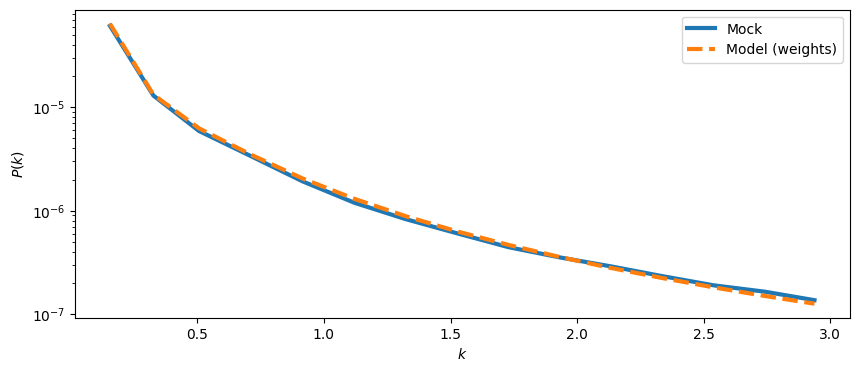

In [49]:
plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(keff,power_1d_hi_mock,label='Mock',ls='-',lw=3)
ax.plot(keff,power_1d_hi_model,label='Model (weights)',ls='--',lw=3)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')

ax.set_yscale('log')
ax.legend()

In [50]:
# now checking cross-power
mock.mean_center_1 = False
mock.unitless_1 = False
mock.mean_center_2 = True
mock.unitless_2 = True

# field 1 is just HI field, only grid field
mock.field_1 = mock.data
mock.weights_grid_1 = mock.w_HI * windows.blackmanharris(mock.box_ndim[-1])[None,None,:]
mock.weights_field_1 = None

# field 2 is the galaxy field, only field level weights
mock.field_2 = gal_count
mock.weights_field_2 = wf_gal.copy()
mock.weights_grid_2 = None
power_1d_x_mock,keff,nmodes = mock.get_1d_power(mock.cross_power_3d)
power_1d_x_model,_,_ = mock.get_1d_power(mock.cross_power_tracer_model)


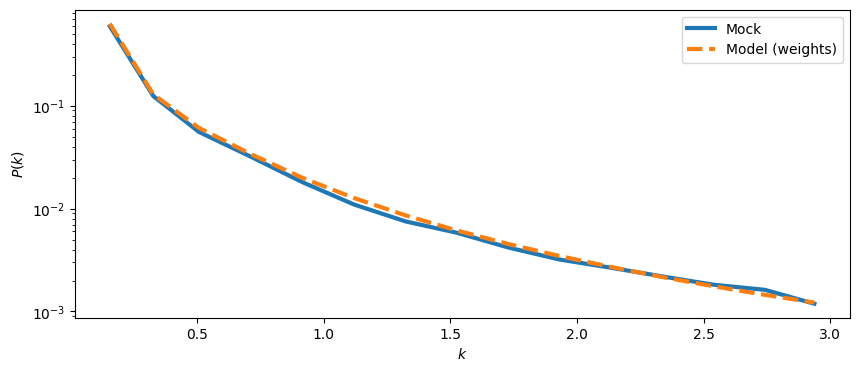

In [51]:
plt.figure(figsize=(10,4))
ax = plt.gca()
ax.plot(keff,power_1d_x_mock,label='Mock',ls='-',lw=3)
ax.plot(keff,power_1d_x_model,label='Model (weights)',ls='--',lw=3)
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')

ax.set_yscale('log')
ax.legend()

In practice, all renormalisations are turned on by default. Switch it off by setting `weights=None` only when you know what you are doing. One useful aspect of turning off the renormalisation is to check the shot-noise contribution in its original amplitude, to match with the 1/N expectation (if the gridding scheme is 'nnb'). 